In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import adjustText
import story_helper

def get_word_chunks(t):
    # split words based on timing into bins of 2 seconds
    word_chunks = []
    current_time = 0
    for i in range(len(t)):
        if i == 0:
            word_chunks.append([t['word'][i]])
        elif t['time_running'][i] - current_time < 2:
            word_chunks[-1].append(t['word'][i])
        else:
            word_chunks.append([t['word'][i]])
            current_time += 2
    return word_chunks

In [ ]:
pilot_data_dir = "/home/chansingh/mntv1/deep-fMRI/story_data/20230504"
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {k: np.load(join(pilot_data_dir, k)) for k in tqdm(resp_np_files)}
story_data = joblib.load(join(sasc.config.RESULTS_DIR, 'pilot_story_data.pkl'))

In [ ]:
story_num = 1
paragraphs = story_data["story_text"][story_num].split("\n\n")
rows = story_data['rows'][story_num]
voxel_nums = rows['voxel_num']
expls = rows['expl']
t = story_data['timing'][story_num]

r_curves = resps_dict[story_data["story_name_new"][story_num]].T[voxel_nums]
word_chunks = get_word_chunks(t)
start_times, end_times = story_helper.get_start_end_times(t, paragraphs)

In [67]:
rows[['expl', 'voxel_num']]

,expl,voxel_num
0,rejection,22840
1,emotional expression,29688
2,locations,61584
3,laughter,22994
4,hair and clothing,59916
5,time,23386
6,death,32670
7,measurements,47687
8,physical injury or trauma,43198
9,emotion,3947


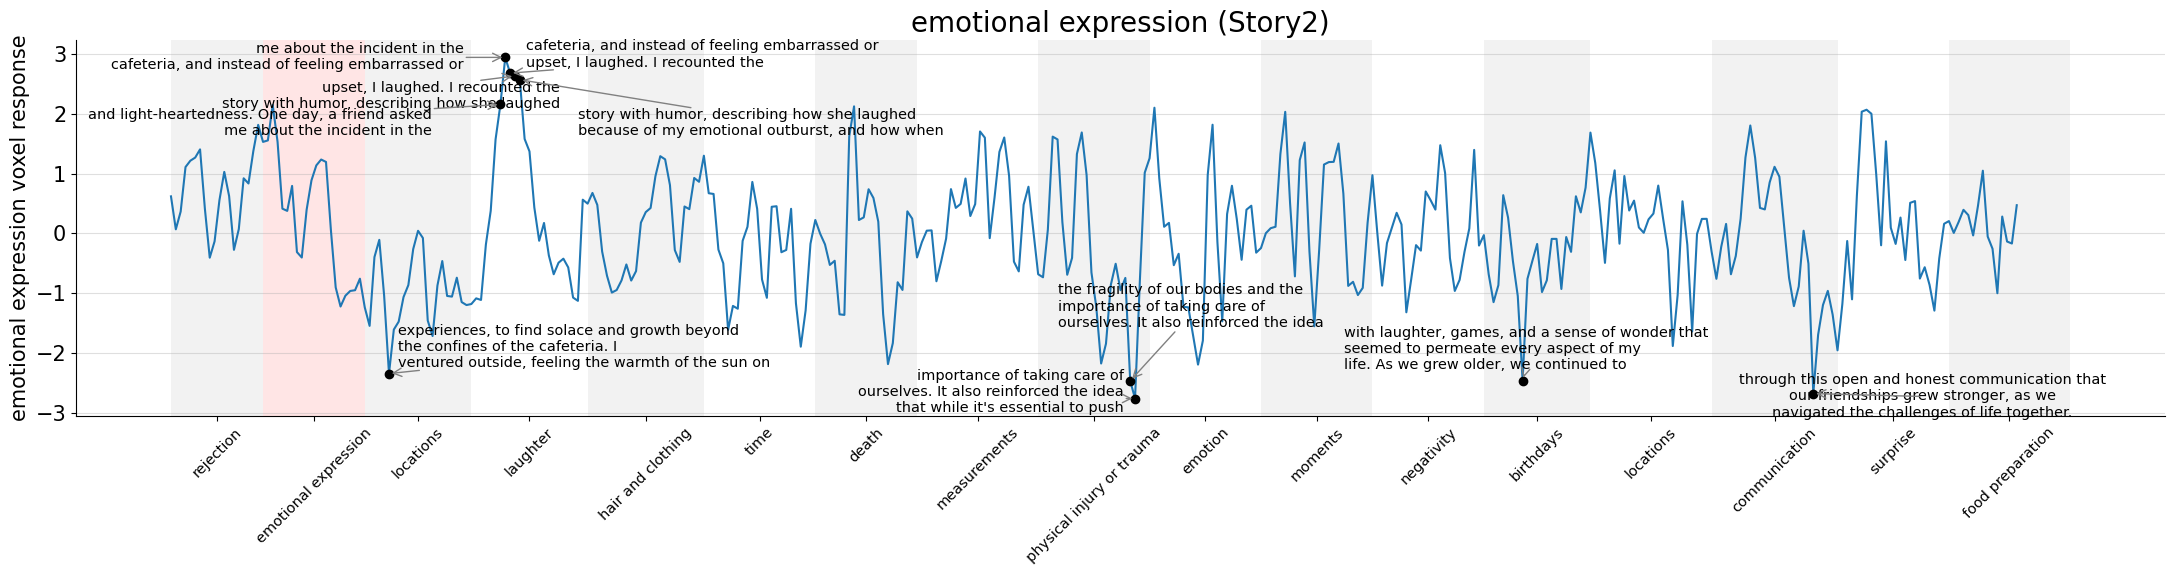

In [74]:
voxel_num = 1
expl_voxel = expls[voxel_num]
plt.figure(figsize=(22, 6))
voxel_resp = r_curves[voxel_num]
plt.title(f'{expl_voxel} ({story_data["story_name_new"][story_num][3:-10]})')
plt.plot(voxel_resp)

# annotate top 5 voxel_resps with word_chunks
texts = []
top_5_resp_positions = np.argsort(voxel_resp)[::-1][:5]
for i, resp_position in enumerate(top_5_resp_positions):
    plt.plot(resp_position, voxel_resp[resp_position], 'o', color='black')
    text = ' '.join(word_chunks[resp_position - 1]) + '\n' + ' '.join(word_chunks[resp_position])
    texts.append(plt.annotate(text, (resp_position, voxel_resp[resp_position]), fontsize='x-small'))

# annotate bottom 5 voxel_resps with word_chunks
bottom_5_resp_positions = np.argsort(voxel_resp)[:5]
for i, resp_position in enumerate(bottom_5_resp_positions):
    plt.plot(resp_position, voxel_resp[resp_position], 'o', color='black')
    text = ' '.join(word_chunks[resp_position - 2]) + '\n' + \
        ' '.join(word_chunks[resp_position - 1]) + '\n' + \
        ' '.join(word_chunks[resp_position])
    texts.append(plt.annotate(text, (resp_position, voxel_resp[resp_position]), fontsize='x-small'))

adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
plt.grid(alpha=0.4, axis='y')
xticks = np.array([start_times, end_times]).mean(axis=0)
plt.xticks(xticks, expls, rotation=45, fontsize='x-small')

for i, (start_time, end_time) in enumerate(zip(start_times, end_times)):
    if i == voxel_num:
        plt.axvspan(start_time, end_time, facecolor='red', alpha=0.1)
    elif i % 2 == 0:
        plt.axvspan(start_time, end_time, facecolor='gray', alpha=0.1)
    else:
        plt.axvspan(start_time, end_time, facecolor='gray', alpha=0.0)
# plt.grid(xdata=end_times)
plt.ylabel(f'{expl_voxel} voxel response')
plt.show()
